<a href="https://colab.research.google.com/github/javadvahid/deepLearning/blob/main/CryptoPricePredictionPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#read data download from cryptodatadownload.com
data = pd.read_csv("/content/Bitfinex_BTCUSD_d.csv")

In [3]:
data.head()


,unix,date,symbol,open,high,low,close,Volume USD,Volume BTC
0,1.423440e+09,2/9/2015 0:00,BTC/USD,224.22,225.00,215.40,220.61,6493501.42,29625.03
1,1.423526e+09,2/10/2015 0:00,BTC/USD,220.61,223.88,214.00,220.96,6402350.57,29268.95
2,1.423613e+09,2/11/2015 0:00,BTC/USD,220.96,224.40,218.10,219.19,4268986.79,19289.28
3,1.423699e+09,2/12/2015 0:00,BTC/USD,219.19,223.20,217.87,222.60,2468883.37,11190.65
4,1.423786e+09,2/13/2015 0:00,BTC/USD,222.39,241.76,221.46,236.00,6806972.89,29079.11


In [4]:
#we only use the Close price of each day
dataPrice = data.close

In [5]:
dataPrice.shape

(2339,)

In [6]:
#preparing train(80%) and test(20%) data
idx = np.int(len(dataPrice)*0.8)
dp_train = dataPrice[:idx].values # 80%  for train
dp_test = dataPrice[idx:].values # 20%  for test

In [7]:
#scaling data to the range of [0 1]

#finding the Min and the Max of data
scaler = MinMaxScaler().fit(dataPrice.values.reshape(-1,1)) 
#transforming data using the Max and Min to the range of [0 1]. you can also do that in 1 step using MinMaxScaler().fit_transform(data)
dp_train = scaler.transform(dp_train.reshape(-1,1)) 
print(dp_train.shape)
#do the same for test dataset
dp_test = scaler.transform(dp_test.reshape(-1,1))


#creating X and Y for Train and Test
nod = 20 #Number Of Days used for predicting the next day's price
x_train = []
y_train = []
x_test = []
y_test = []
for i in range (len(dp_train) - nod):
  x_train.append(dp_train[i:(i+nod)])
  y_train.append(dp_train[i + nod])

for j in range (len(dp_test) - nod):
  x_test.append(dp_test[j:(j+nod)])
  y_test.append(dp_test[j + nod])  



# LSTM Layer in Pytorch get an input of size (N, L, H) when batch_first is True  
x_train = torch.from_numpy(np.array(x_train).astype(np.float32)) 
y_train = torch.from_numpy(np.array(y_train).astype(np.float32))
x_test = torch.from_numpy(np.array(x_test).astype(np.float32))

(1871, 1)


In [8]:
#add more layers to model
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.lstm1 = nn.LSTM(input_size = 1, hidden_size = 20, batch_first = True)
    self.dropout = nn.Dropout(p=0.3)
    self.linear1 = nn.Linear(20, 4)
    self.linear2 = nn.Linear(4, 1)
  def forward(self, x):
    x, c = self.lstm1(x)
    x = self.dropout(x)
    x = self.linear1(x[:,-1,:])
    x = self.linear2(x)
    return x  

In [9]:
model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
print(model)

Model(
  (lstm1): LSTM(1, 20, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=20, out_features=4, bias=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [10]:
#train
epochs = 3000
for i in range(epochs):
  model.zero_grad()
  output = model(x_train)
  loss = criterion(output, y_train)
  if i % 20 == 0:
        print("epoch {}   loss: {} ".format(i, loss.item()))
  loss.backward()
  optimizer.step()


epoch 0   loss: 0.016241542994976044 
epoch 20   loss: 0.0042374636977910995 
epoch 40   loss: 0.003982906229794025 
epoch 60   loss: 0.0037330028135329485 
epoch 80   loss: 0.00339742680080235 
epoch 100   loss: 0.002534460509195924 
epoch 120   loss: 0.0008142633596435189 
epoch 140   loss: 0.0007658347021788359 
epoch 160   loss: 0.0006824207957834005 
epoch 180   loss: 0.0005984745803289115 
epoch 200   loss: 0.0005586991901509464 
epoch 220   loss: 0.0004920832579955459 
epoch 240   loss: 0.0005100631387904286 
epoch 260   loss: 0.0004202769778203219 
epoch 280   loss: 0.00043632526649162173 
epoch 300   loss: 0.00041250549838878214 
epoch 320   loss: 0.0003612494620028883 
epoch 340   loss: 0.0003383237053640187 
epoch 360   loss: 0.00034648741711862385 
epoch 380   loss: 0.00031851802486926317 
epoch 400   loss: 0.0003053458349313587 
epoch 420   loss: 0.00028831182862631977 
epoch 440   loss: 0.00031104322988539934 
epoch 460   loss: 0.00028034974820911884 
epoch 480   loss: 0.

torch.Size([1851, 1])
(1851, 1)
(1851, 1)


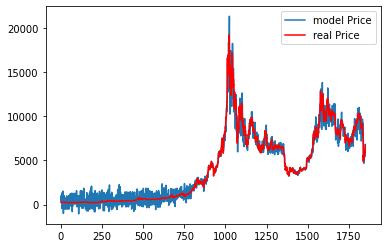

In [11]:
# test on training data

Price = model(x_train)
print(Price.shape)
predPrice = scaler.inverse_transform(Price.detach().numpy().reshape(-1, 1))
print(predPrice.shape)
realPrice = scaler.inverse_transform(y_train)
print(realPrice.shape)
plt.plot(range(predPrice.shape[0]), predPrice, label='model Price')
plt.plot(range(realPrice.shape[0]), realPrice, 'r', label='real Price')
plt.legend()
plt.show()

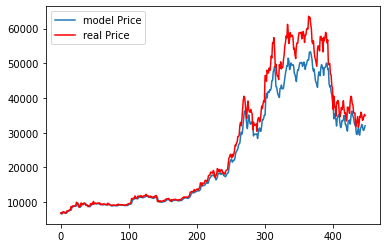

In [13]:
# test
model.eval() #to deactivate the dropout Layer
predPrice = model(x_test)
predPrice = scaler.inverse_transform(predPrice.detach().numpy().reshape(-1, 1))
realPrice = scaler.inverse_transform(y_test)
plt.plot(range(predPrice.shape[0]), predPrice, label='model Price')
plt.plot(range(realPrice.shape[0]), realPrice, 'r', label='real Price')
plt.legend()
plt.savefig('btcprice.png')
plt.show()
